In [1]:
# Author: Riley Owens (GitHub: mrileyowens)

# This file measures the FWHM and peak
# separation of a Lyα profile and estimates
# the associated error.

In [2]:
import sys

import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=100
plt.rcParams['lines.linewidth']=0.5

from scipy.optimize import curve_fit

In [3]:
def gaussFit(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
    
def fitNormPeak(vArr,fArr,sampleMin,sampleMax,params,bounds):

    fArr=fArr[vArr > sampleMin]
    vArr=vArr[vArr > sampleMin]
    fArr=fArr[vArr < sampleMax]
    vArr=vArr[vArr < sampleMax]

    popt,pcov=curve_fit(gaussFit,vArr,fArr,p0=params,bounds=bounds)

    return popt,pcov

def centroid(vArr,fArr,Min,Max):
    
    mask=((vArr>Min) & (vArr<Max)).astype(int)
    fArrMask=fArr*mask
    i=np.argmax(fArrMask)
    a1=(fArrMask[i+1]-fArrMask[i-1])/2
    a2=(fArrMask[i+1]+fArrMask[i-1]-2*fArrMask[i])/2
    
    ctrPix=i-(a1/(2*a2))
    
    ctr=((vArr[-1]-vArr[-2])*(ctrPix-i))+vArr[i]
    
    return ctr

def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y, Min, Max):
    
    y=np.where(x>Min,y,0.0)
    y=np.where(x<Max,y,0.0)
    
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)],half

def v2w(v,redshift):
    
    w=1215.67*(1.0+redshift)*(1.0+(v/3e5))
    
    return w

def cont(wArr,fArr,Min,Max):
    
    fArr=fArr[wArr > Min]
    wArr=wArr[wArr > Min]
    fArr=fArr[wArr < Max]
    wArr=wArr[wArr < Max]
    
    cont=np.mean(fArr)
    
    return cont

def binc(x):
    
    q25, q75 = np.percentile(x, [0.25, 0.75])
    bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
    bins = round((x.max() - x.min()) / bin_width)
    
    return bins
    

In [4]:
# Establishing directories and filepaths
home='C://Users/15136/OneDrive - University of Cincinnati/Documents/Research/sunburstarc'
data=home+'/data/spectra/mage'
figs=home+'/figs'

In [5]:
wlabel='Wavelength (Å)'
vlabel='Velocity (km s$^{-1}$)'
flabel='Flux (10$^{-16}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)'

In [6]:
df=pd.read_csv(data+'/slits.txt',delimiter=' ',header=0)

slits=df.iloc[:,0].to_numpy(dtype=str)
files=df.iloc[:,1].to_numpy(dtype=str)
z=df.iloc[:,2].to_numpy(dtype=np.float64)

ampGuess=df.iloc[:,3].to_numpy()
ctrGuess=df.iloc[:,4].to_numpy()
stdGuess=df.iloc[:,5].to_numpy()

Min=df.iloc[:,6].to_numpy(dtype=np.float64)
Max=df.iloc[:,7].to_numpy(dtype=np.float64)

ctrLBnd=df.iloc[:,8].to_numpy(dtype=np.float64)
stdLBnd=df.iloc[:,9].to_numpy(dtype=np.float64)
ctrUBnd=df.iloc[:,10].to_numpy(dtype=np.float64)
stdUBnd=df.iloc[:,11].to_numpy(dtype=np.float64)

contLBnd=df.iloc[:,12].to_numpy(dtype=np.float64)
contUBnd=df.iloc[:,13].to_numpy(dtype=np.float64)

cPeak=df.iloc[:,14].to_numpy(dtype=bool)
bPeak=df.iloc[:,15].to_numpy()

c:\users\15136\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


AttributeError: 'Figure' object has no attribute 'xlabel'

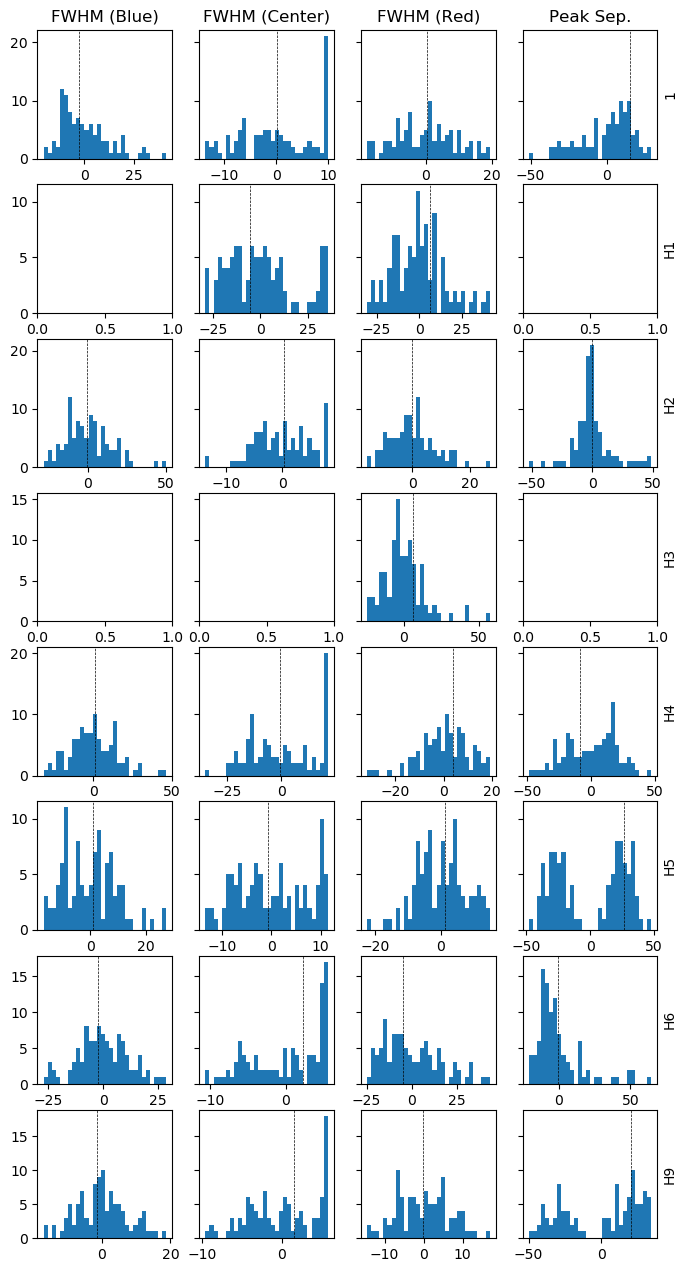

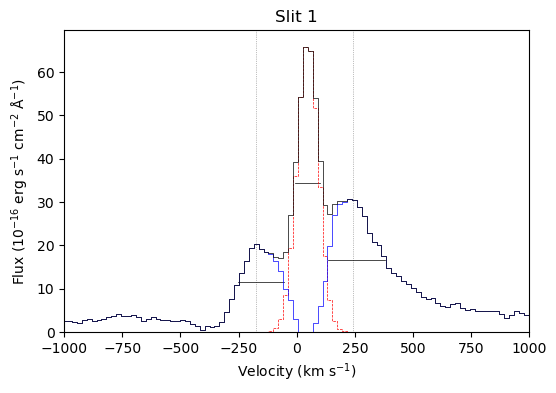

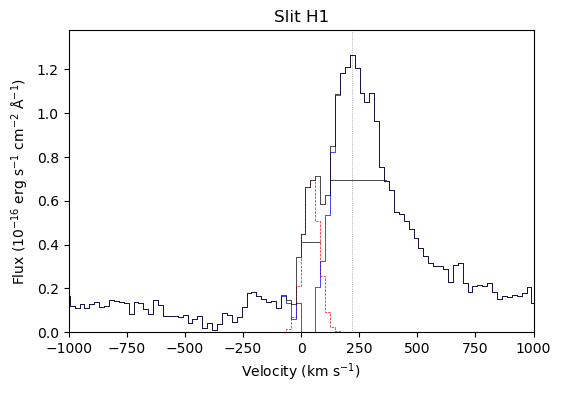

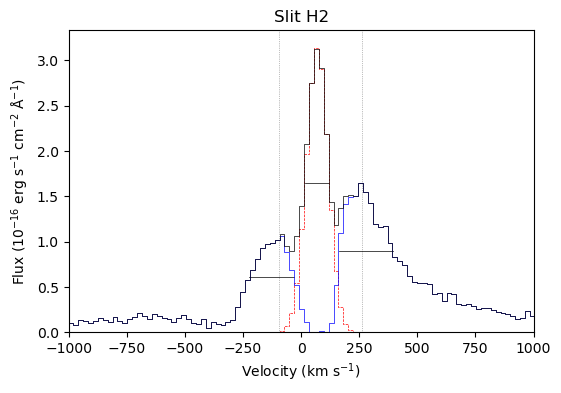

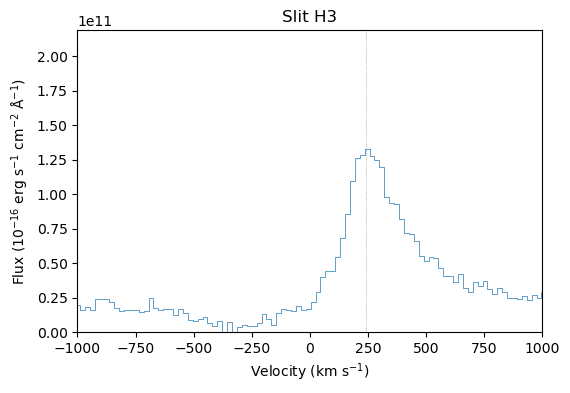

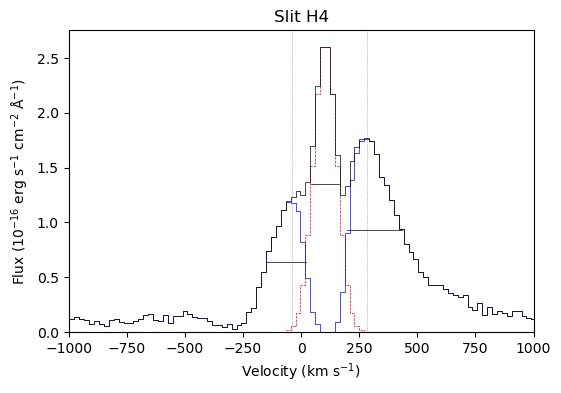

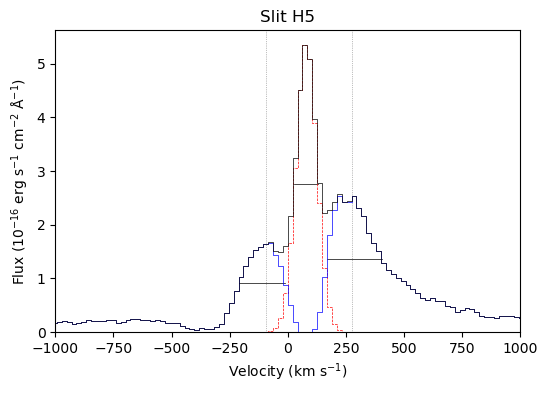

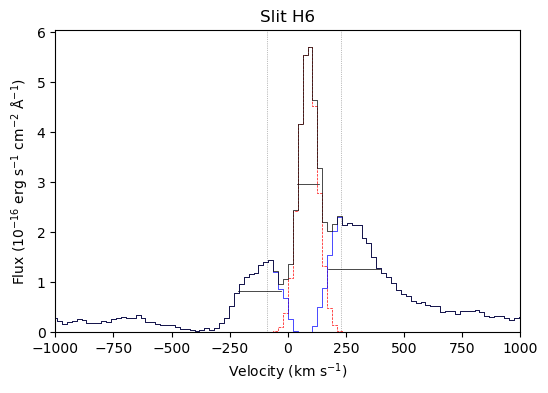

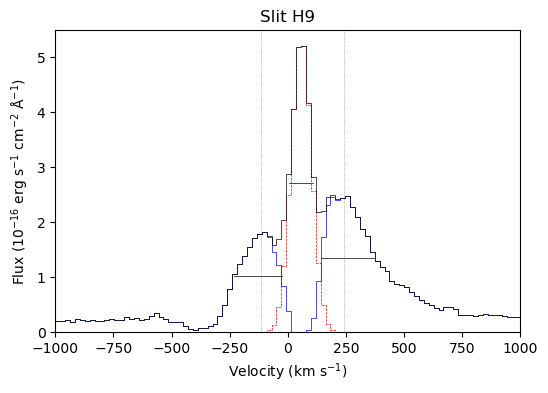

In [7]:
figErr,axErr=plt.subplots(8,4,figsize=(8,16),sharey='row')

for i in np.indices(np.shape(slits)).flatten():
    
    #Converting .txt file into a data frame
    dataFrame=pd.read_csv(data+'/'+files[i],delimiter='\t',header=0,skiprows=13)

    #Discarding missing data
    dataFrame=dataFrame.apply(pd.to_numeric,errors='coerce').dropna()

    #Discarding extreme outliers
    dataFrame=dataFrame[dataFrame.iloc[:,1]<1e-20]

    #Resetting the index
    dataFrame=dataFrame.reset_index(drop=True)

    # Extracting wavelength, flux, and noise
    wArr=dataFrame.iloc[:,0].to_numpy()
    fArr=(dataFrame.iloc[:,1].to_numpy())*((2.998e18)/(np.square(wArr)))
    nArr=(dataFrame.iloc[:,2].to_numpy())*((2.998e18)/(np.square(wArr)))

    # Converting wavelength to peculiar velocity
    # of Lyman-α line
    vArr=(3e5)*(((wArr/(1+np.float64(z[i])))/1215.67)-1)
    
    title='Slit '+slits[i]
    
    if cPeak[i]==True & bPeak[i]==True:
        
        fitGuess=(ampGuess[i],ctrGuess[i],stdGuess[i])
        sampleRange=(Min[i],Max[i])
        
        popt,pcov=fitNormPeak(vArr,fArr*1e16,*sampleRange,params=fitGuess,bounds=([0.0,ctrLBnd[i],0.0],[np.inf,ctrUBnd[i],stdUBnd[i]]))
        
        ctrB=centroid(vArr,fArr*1e16-gaussFit(vArr,*popt),-250.0,popt[1])
        ctrR=centroid(vArr,fArr*1e16-gaussFit(vArr,*popt),popt[1],500.0)
        
        cntm=cont(wArr,fArr*1e16,contLBnd[i],contUBnd[i])
        
        hmxB,halfB=half_max_x(vArr,fArr*1e16-gaussFit(vArr,*popt)-cntm,-750.0,popt[1])
        hmxR,halfR=half_max_x(vArr,fArr*1e16-gaussFit(vArr,*popt)-cntm,popt[1],750.0)
        hmxC,halfC=half_max_x(vArr,gaussFit(vArr,*popt)-cntm,-1000.0,1000.0)
        
        fig,ax=plt.subplots(1,1)
        
        ax.axvline(ctrB,c='gray',ls='dotted')
        ax.axvline(ctrR,c='gray',ls='dotted')

        #plt.plot(vArr,fArr*1e27-gaussFit(vArr,*popt)-cntm,ds='steps-mid')
        plt.plot(hmxB, [halfB+cntm, halfB+cntm],c='black')
        plt.plot(hmxC,[halfC+cntm,halfC+cntm],c='black')
        plt.plot(hmxR, [halfR+cntm, halfR+cntm],c='black')
        
        plt.plot(vArr,gaussFit(vArr,*popt),ds='steps-mid',ls='dashed',c='red')
        
        plt.plot(vArr,fArr*1e16-gaussFit(vArr,*popt),ds='steps-mid',c='blue')
        
        plt.plot(vArr,fArr*1e16,ds='steps-mid',c='black')

        ax.set_xlim(-1000.0,1000.0)
        ax.set_ylim(0.0)
        plt.title(title)
        ax.set_xlabel(vlabel)
        ax.set_ylabel(flabel)
        
        plt.savefig(figs+'/'+slits[i]+'ctrfwhm.png',dpi=100,bbox_inches='tight')
        
        n=0
        fwhmRArr=np.array([])
        fwhmCArr=np.array([])
        fwhmBArr=np.array([])
        psepArr=np.array([])
        
        while n!=100:
    
            smthg=np.random.normal(fArr,nArr)
    
            popt1,pcov1=fitNormPeak(vArr,smthg*1e16,*sampleRange,params=popt,bounds=([0.0,ctrLBnd[i],0.0],[np.inf,ctrUBnd[i],stdUBnd[i]]))
    
            peak=gaussFit(vArr,*popt1)
            noCPeak=smthg*1e16-gaussFit(vArr,*popt1)
    
            ctrBN=centroid(vArr,smthg*1e16-gaussFit(vArr,*popt1),-250.0,popt1[1])
            ctrRN=centroid(vArr,smthg*1e16-gaussFit(vArr,*popt1),popt1[1],500.0)
    
            psepN=ctrRN-ctrBN
    
            hmxRN,halfRN=half_max_x(vArr,noCPeak-cntm,popt1[1],750.0)
            hmxCN,halfCN=half_max_x(vArr,peak-cntm,-1000.0,1000.0)
            hmxBN,halfBN=half_max_x(vArr,noCPeak-cntm,-750.0,popt1[1])
    
            #plt.plot(vArr,smthg*1e16-gaussFit(vArr,*popt1),c='blue',ds='steps-mid')
            #plt.plot(vArr,smthg*1e16,c='black',ds='steps-mid')
            #plt.plot(vArr,gaussFit(vArr,*popt1),ls='dashed',c='red',ds='steps-mid')
            #plt.plot(hmxRN,[halfRN+cntm,halfRN+cntm],c='black')
            #plt.plot(hmxCN,[halfCN+cntm,halfCN+cntm],c='black')
            #plt.plot(hmxBN,[halfBN+cntm,halfBN+cntm],c='black')
            #plt.axvline(ctrRN,ls='-')
            #plt.axvline(ctrBN,ls='-')
            #plt.xlim(-1000.0,1000.0)
            #plt.title(slits[i])
            #plt.show()
    
            #print(*popt1)
    
            fwhmRN=np.array([hmxRN[1]-hmxRN[0]])
            fwhmCN=np.array([hmxCN[1]-hmxCN[0]])
            fwhmBN=np.array([hmxBN[1]-hmxBN[0]])
    
            fwhmRArr=np.append(fwhmRArr,fwhmRN)
            fwhmCArr=np.append(fwhmCArr,fwhmCN)
            fwhmBArr=np.append(fwhmBArr,fwhmBN)
            psepArr=np.append(psepArr,psepN)
    
            n=n+1
        
        axErr[i,2].hist((fwhmRArr-np.mean(fwhmRArr)),bins=30)
        axErr[i,2].axvline(((hmxR[1]-hmxR[0])-np.mean(fwhmRArr)),ls='dashed',c='black')
        #axErr[i,2].set_aspect(1./axErr[i,2].get_data_ratio())
        if i==0:
            axErr[i,2].set_title('FWHM (Red)')

        axErr[i,1].hist((fwhmCArr-np.mean(fwhmCArr)),bins=30)
        axErr[i,1].axvline(((hmxC[1]-hmxC[0])-np.mean(fwhmCArr)),ls='dashed',c='black')
        #axErr[i,1].set_aspect(1./axErr[i,1].get_data_ratio())
        if i==0:
            axErr[i,1].set_title('FWHM (Center)')

        axErr[i,0].hist((fwhmBArr-np.mean(fwhmBArr)),bins=30)
        axErr[i,0].axvline(((hmxB[1]-hmxB[0])-np.mean(fwhmBArr)),ls='dashed',c='black')
        #axErr[i,0].set_aspect(1./axErr[i,0].get_data_ratio())
        if i==0:
            axErr[i,0].set_title('FWHM (Blue)')

        axErr[i,3].hist((psepArr-np.mean(psepArr)),bins=30)
        axErr[i,3].axvline(((ctrR-ctrB)-np.mean(psepArr)),ls='dashed',c='black')
        #axErr[i,3].set_aspect(1./axErr[i,3].get_data_ratio())
        if i==0:
            axErr[i,3].set_title('Peak Sep.')
        axErr[i,3].yaxis.set_label_position("right")
        axErr[i,3].set_ylabel(slits[i])
        
    elif cPeak[i]==True and bPeak[i]==False:
        
        fitGuess=(ampGuess[i],ctrGuess[i],stdGuess[i])
        sampleRange=(Min[i],Max[i])
        popt,pcov=fitNormPeak(vArr,fArr*1e16,*sampleRange,params=fitGuess,bounds=([0.0,ctrLBnd[i],0.0],[np.inf,ctrUBnd[i],stdUBnd[i]]))
        
        ctrR=centroid(vArr,fArr*1e16-gaussFit(vArr,*popt),popt[1],500.0)
        
        cntm=cont(wArr,fArr*1e16,contLBnd[i],contUBnd[i])
        
        hmxR,halfR=half_max_x(vArr,fArr*1e16-gaussFit(vArr,*popt)-cntm,popt[1],750.0)
        hmxC,halfC=half_max_x(vArr,gaussFit(vArr,*popt)-cntm,-1000.0,1000.0)
        
        fig,ax=plt.subplots(1,1)
        
        ax.axvline(ctrR,c='gray',ls='dotted')

        #plt.plot(vArr,fArr*1e27-gaussFit(vArr,*popt)-cntm,ds='steps-mid')
        plt.plot(hmxC,[halfC+cntm,halfC+cntm],c='black')
        plt.plot(hmxR, [halfR+cntm, halfR+cntm],c='black')
        
        plt.plot(vArr,gaussFit(vArr,*popt),ds='steps-mid',ls='dashed',c='red')
        
        plt.plot(vArr,fArr*1e16-gaussFit(vArr,*popt),ds='steps-mid',c='blue')
        
        plt.plot(vArr,fArr*1e16,ds='steps-mid',c='black')

        ax.set_xlim(-1000.0,1000.0)
        ax.set_ylim(0.0)
        plt.title(title)
        ax.set_xlabel(vlabel)
        ax.set_ylabel(flabel)
        
        plt.savefig(figs+'/'+slits[i]+'ctrfwhm.png',dpi=100,bbox_inches='tight')
        
        n=0
        fwhmRArr=np.array([])
        fwhmCArr=np.array([])
        fwhmBArr=np.array([])
        psepArr=np.array([])
        
        while n!=100:
    
            smthg=np.random.normal(fArr,nArr)
    
            popt1,pcov1=fitNormPeak(vArr,smthg*1e16,*sampleRange,params=popt,bounds=([0.0,ctrLBnd[i],0.0],[np.inf,ctrUBnd[i],stdUBnd[i]]))
    
            peak=gaussFit(vArr,*popt1)
            noCPeak=smthg*1e16-gaussFit(vArr,*popt1)
        
            hmxRN,halfRN=half_max_x(vArr,noCPeak-cntm,popt1[1],750.0)
            hmxCN,halfCN=half_max_x(vArr,peak-cntm,-1000.0,1000.0)

            #plt.plot(vArr,smthg*1e16-gaussFit(vArr,*popt1),c='blue',ds='steps-mid')
            #plt.plot(vArr,smthg*1e16,c='black',ds='steps-mid')
            #plt.plot(vArr,gaussFit(vArr,*popt1),ls='dashed',c='red',ds='steps-mid')
            #plt.plot(hmxRN,[halfRN+cntm,halfRN+cntm],c='black')
            #plt.plot(hmxCN,[halfCN+cntm,halfCN+cntm],c='black')
            #plt.axvline(ctrR,ls='-')
            #plt.xlim(-1000.0,1000.0)
            #plt.title(slits[i])
            #plt.show()
    
            #print(*popt1)
    
            fwhmRN=np.array([hmxRN[1]-hmxRN[0]])
            fwhmCN=np.array([hmxCN[1]-hmxCN[0]])
            
            fwhmRArr=np.append(fwhmRArr,fwhmRN)
            fwhmCArr=np.append(fwhmCArr,fwhmCN)
            
            n=n+1
        
        axErr[i,2].hist((fwhmRArr-np.mean(fwhmRArr)),bins=30)
        axErr[i,2].axvline(((hmxR[1]-hmxR[0])-np.mean(fwhmRArr)),ls='dashed',c='black')
        #axErr[i,2].set_aspect(1./axErr[i,2].get_data_ratio())
        if i==0:
            axErr[i,2].set_title('FWHM (Red)')

        axErr[i,1].hist((fwhmCArr-np.mean(fwhmCArr)),bins=30)
        axErr[i,1].axvline(((hmxC[1]-hmxC[0])-np.mean(fwhmCArr)),ls='dashed',c='black')
        #axErr[i,1].set_aspect(1./axErr[i,1].get_data_ratio())
        if i==0:
            axErr[i,1].set_title('FWHM (Center)')
        
        #axErr[i,0].set_aspect(1./axErr[i,2].get_data_ratio())
        
        #axErr[i,3].set_aspect(1./axErr[i,2].get_data_ratio())
        axErr[i,3].yaxis.set_label_position("right")
        axErr[i,3].set_ylabel(slits[i])

    elif cPeak[i]==False and bPeak[i]==False:
        
        ctrR=centroid(vArr,fArr*1e16,0.0,500.0)
        
        cntm=cont(wArr,fArr*1e16,contLBnd[i],contUBnd[i])
        
        hmxR,halfR=half_max_x(vArr,fArr*1e16-cntm,0.0,750.0)
        
        fig,ax=plt.subplots(1,1)
        
        ax.axvline(ctrR,c='gray',ls='dotted')

        plt.plot(vArr,fArr*1e27-gaussFit(vArr,*popt)-cntm,ds='steps-mid')
        plt.plot(hmxR, [halfR+cntm, halfR+cntm],c='black')
        
        plt.plot(vArr,fArr*1e16,ds='steps-mid',c='black')

        ax.set_xlim(-1000.0,1000.0)
        ax.set_ylim(0.0)
        plt.title(title)
        ax.set_xlabel(vlabel)
        ax.set_ylabel(flabel)
        
        plt.savefig(figs+'/'+slits[i]+'ctrfwhm.png',dpi=100,bbox_inches='tight')
        
        #plt.close('all')
        
        n=0
        fwhmRArr=np.array([])
        
        while n!=100:
    
            smthg=np.random.normal(fArr,nArr)
    
            hmxRN,halfRN=half_max_x(vArr,smthg*1e16-cntm,0.0,750.0)
    
            #plt.plot(vArr,smthg*1e16,c='black',ds='steps-mid')
            #plt.plot(vArr,nArr*1e16,c='black',ds='steps-mid')
            #plt.plot(hmxRN,[halfRN+cntm,halfRN+cntm],c='black')
            #plt.axvline(ctrR,ls='-')
            #plt.xlim(-1000.0,1000.0)
            #plt.title(slits[i])
            #plt.show()
    
            fwhmRN=hmxRN[1]-hmxRN[0]
            
            fwhmRArr=np.append(fwhmRArr,fwhmRN)
            
            n=n+1
        
        axErr[i,2].hist((fwhmRArr-np.mean(fwhmRArr)),bins=30)
        axErr[i,2].axvline(((hmxR[1]-hmxR[0])-np.mean(fwhmRArr)),ls='dashed',c='black')
        #axErr[i,2].set_aspect(1./axErr[i,2].get_data_ratio())
        
        #axErr[i,0].set_aspect(1./axErr[i,2].get_data_ratio())
        
        #axErr[i,1].set_aspect(1./axErr[i,2].get_data_ratio())
        
        #axErr[i,3].set_aspect(1./axErr[i,2].get_data_ratio())
        axErr[i,3].yaxis.set_label_position("right")
        axErr[i,3].set_ylabel(slits[i])
    
figErr.tight_layout()

figErr.savefig(figs+'/err.png',dpi=100,bbox_inches='tight')

plt.show()

In [ ]:
# Converting FWHM to wavelength-space
#fwhmRw=v2w(hmxR[1],redshift)-v2w(hmxR[0],redshift)
#fwhmCw=v2w(hmxC[1],redshift)-v2w(hmxC[0],redshift)
#fwhmBw=v2w(hmxB[1],redshift)-v2w(hmxB[0],redshift)

#fwhmRv=hmxR[1]-hmxR[0]
#fwhmCv=hmxC[1]-hmxC[0]
#fwhmBv=hmxB[1]-hmxB[0]

#print("fwhmRw:{:.10f}".format(fwhmRw))
#print("fwhmCw:{:.10f}".format(fwhmCw))
#print("fwhmBw:{:.10f}".format(fwhmBw))

#print("fwhmRv:{:.10f}".format(fwhmRv))
#print("fwhmCv:{:.10f}".format(fwhmCv))
#print("fwhmBv:{:.10f}".format(fwhmBv))

In [ ]:
#fwhmRErr=np.std(fwhmRArr)
#fwhmCErr=np.std(fwhmCArr)
#fwhmBErr=np.std(fwhmBArr)
#psepErr=np.std(psepArr)

#print(fwhmRErr,fwhmCErr,fwhmBErr,psepErr)